Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.'  # Change me to store data elsewhere


def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename


train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10  # From A to J

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders


train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
import random
np.random.seed(42)   # Use the same set of random numbers

def display_sample_image(folder):
    fig = plt.figure(figsize=(18,5))
    count=1
    # Go through the folders from "A" to "J"
    for dirs in folder:
        # Choose a random image 
        image_name = random.choice(os.listdir(dirs))
        # Get the path of the image file
        image_file = os.path.join(dirs, image_name)
        # Display the image
        # display(Image(image_file))
        fig.add_subplot(1, 10, count)
        count+=1
        plt.axis('off')
        plt.imshow(plt.imread(image_file))
    return

Samples of training images:


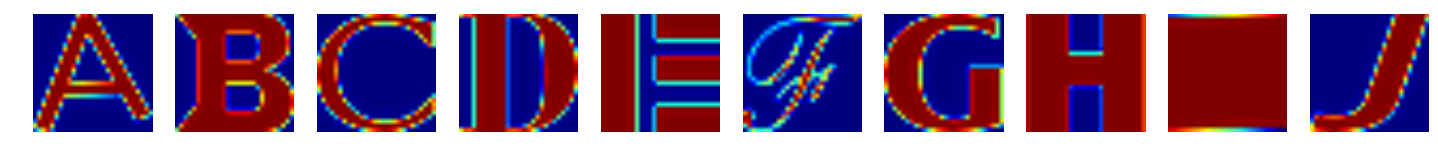

In [5]:
print("Samples of training images:")
display_sample_image(train_folders)

Samples of testing images:


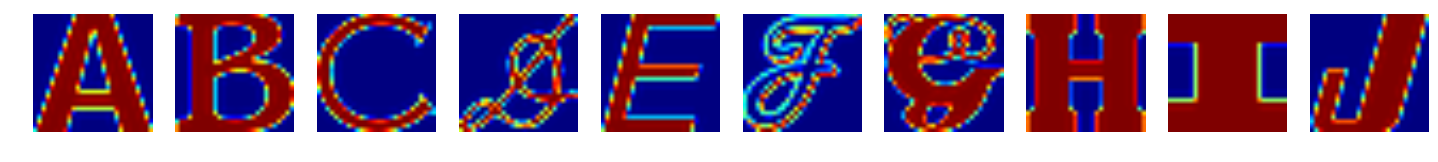

In [6]:
print("Samples of testing images:")
display_sample_image(test_folders)

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.


def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names


train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [8]:
def disp_10_img(imgs):
    """Display subplot with 10 images or less"""
    fig = plt.figure(figsize=(18,5))
    for i, img in enumerate(imgs):
        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(img)
        
def load(filename):
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f) #, encoding = 'latin1'
    except Exception as e:
        print('Unable to read data from', filename, ':', e)
        

def disp_sample_pickles(data_folders):
    # Choose a folder from "A" to "J"
    folder = random.sample(data_folders, 1)   #list
    pickle_filename = ''.join(folder)         #string
    # Load the random letter's images
    dataset = load(pickle_filename)
    print(pickle_filename)
    disp_10_img(random.sample(list(dataset), 10))

In [9]:
disp_sample_pickles(train_datasets)

Unable to read data from .\notMNIST_large\F.pickle : 'ascii' codec can't decode byte 0xbf in position 3: ordinal not in range(128)
.\notMNIST_large\F.pickle


TypeError: 'NoneType' object is not iterable

In [ ]:
disp_sample_pickles(test_datasets)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [ ]:
def number_images(data_folders):
    numlist = {}
    for pickle_filename in data_folders:
        dataset = load(pickle_filename)
        numlist[pickle_filename]= len(dataset)
    return pd.DataFrame( {'Number of images': numlist})

In [ ]:
display(number_images(train_datasets))
display(number_images(test_datasets))

In [ ]:
number_images(train_datasets).plot.bar(figsize=(5, 5),rot=-85, legend=False);

In [ ]:
number_images(test_datasets).plot.bar(figsize=(5, 5),rot=-85, legend=False);

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [ ]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels


def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f, encoding = 'latin1') #, encoding='latin1'
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels


train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [ ]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [ ]:
def verify_dataset(dataset, labels, size = 5):
    fig = plt.figure(figsize=(18,5))
    items = random.sample(range(len(labels)), size)
    for i, item in enumerate(items):
        plt.subplot(1, size, i+1)
        plt.axis('off')
        plt.title("Image should be %s" % chr(ord('A')+labels[item]))
        plt.imshow(dataset[item])
    return

In [ ]:
print("Verify training dataset:")
verify_dataset(train_dataset,train_labels)

In [ ]:
print("Verify validation dataset:")
verify_dataset(valid_dataset,valid_labels)

In [ ]:
print("Verify test dataset:")
verify_dataset(test_dataset,test_labels)

Finally, let's save the data for later reuse:

In [ ]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
            'train_dataset': train_dataset,
            'train_labels':  train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels':  valid_labels,
            'test_dataset':  test_dataset,
            'test_labels':   test_labels,
            }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [ ]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
### Courtesy of ronrest
from time import time
# ===================================================
#                                     FIND DUPLICATES
# ===================================================
# Inspired by eythian's method for duplicates
# https://discussions.udacity.com/t/assignment-1-problem-5/45657/10
t0 = time()
# Set data to read only so we can create hashes
train_dataset.flags.writeable = False
test_dataset.flags.writeable  = False
valid_dataset.flags.writeable = False

# Get hashes for all images as a list (to preserve indices)
train_hashes = [hash(image.data) for image in train_dataset]
test_hashes  = [hash(image.data) for image in test_dataset]
valid_hashes = [hash(image.data) for image in valid_dataset]

# Unique set of hashes found in train. And the set of hashes in test and 
# validation that overlap with the hashes the training data
unique_train_hashes  = set(train_hashes)
test_overlap_hashes  = unique_train_hashes.intersection(set(test_hashes))
valid_overlap_hashes = unique_train_hashes.intersection(set(valid_hashes))

# ---------------------------------------------------
#                                 Create Dictionaries
# ---------------------------------------------------
# Dictionary Keys represent every unique hash from the training data.
# Dictionary Values are lists of indices in the corresponding dataset have that 
# hash.

# Initialise the dictionaries with empty lists
train_hash_dict = {val: [] for val in unique_train_hashes}
test_hash_dict  = {val: [] for val in test_overlap_hashes}
valid_hash_dict = {val: [] for val in valid_overlap_hashes}

# For the train set, append the indices to the corresponding hash
filter(lambda kv: train_hash_dict[kv[1]].append(kv[0]), enumerate(train_hashes))  #kv: (-kv[1], kv[0])

# For test set, append indices only if the hash overlaps with train set
for i, image_hash in enumerate(test_hashes):
    if image_hash in test_overlap_hashes:
        test_hash_dict[image_hash].append(i)

# The same for the validation set
for i, image_hash in enumerate(valid_hashes):
    if image_hash in valid_overlap_hashes:
        valid_hash_dict[image_hash].append(i)
print("Found Duplicate indices in", time() - t0, "seconds")

In [ ]:
print("Number of unique train hash: ", len(train_hash_dict))
print("Number of unique valid hash: ", len(valid_hash_dict))
print("Number of unique test hash: ",  len(test_hash_dict))

In [ ]:
### exploration
all_blue = [  arr   for arr in train_hash_dict.values() if len(arr)>100   ][0]#[:100]

print(len(all_blue))

import time
start = time.time()
fig = plt.figure(figsize=(50,50))
for i, item in enumerate(all_blue):
    plt.subplot(20, len(all_blue)/20, i+1)
    plt.axis('off')
    plt.imshow(train_dataset[item])
print("time: ", time.time() -start)

In [ ]:
### exploration
duplicates = [ arr for arr in train_hash_dict.values() if ((len(arr)>=4)&(len(arr)<=10))   ]#[:100]
print(len(duplicates))

s = 15
fig = plt.figure(figsize=(10,20))
for i in range( len(duplicates[:s])):
    ndup = len(duplicates[:s][i]) # number of duplicates
    for j in range(ndup):
        plt.subplot(s, ndup, ndup*i+j+1)
        plt.axis('off')
        plt.title("index:" + str(duplicates[i][j]))
        plt.imshow(train_dataset[duplicates[i][j]])

In [ ]:
def sanitize(dataset, labels, hash_dict):
    new_dataset = [ train_dataset[v[0]] for k, v in hash_dict.iteritems()]
    new_labels  = [ train_labels [v[0]] for k, v in hash_dict.iteritems()]
    return new_dataset, new_labels

new_train_dataset, new_train_labels = sanitize(train_dataset, train_labels, train_hash_dict)
new_valid_dataset, new_valid_labels = sanitize(valid_dataset, valid_labels, valid_hash_dict)
new_test_dataset,  new_test_labels  = sanitize(test_dataset,  test_labels,   test_hash_dict)

In [ ]:
print(len(new_train_dataset))
print(len(new_train_labels))
print("Verify new training dataset:")
verify_dataset(new_train_dataset, new_train_labels)

In [ ]:
print(len(new_valid_dataset))
print(len(new_valid_labels))
print("Verify new validation dataset:")
verify_dataset(new_valid_dataset, new_valid_labels)

In [ ]:
print(len(new_test_dataset))
print(len(new_test_labels))
print("Verify new test dataset:")
verify_dataset(new_test_dataset, new_test_labels)

In [ ]:
pickle_file = os.path.join(data_root, 'notMNIST_sanitize.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
            'train_dataset': np.ndarray(new_train_dataset, dtype=np.float32),
            'train_labels' : np.ndarray(new_train_labels,  dtype=np.int32),
            'valid_dataset': np.ndarray(new_valid_dataset, dtype=np.float32),
            'valid_labels' : np.ndarray(new_valid_labels,  dtype=np.int32),
            'test_dataset' : np.ndarray(new_test_dataset,  dtype=np.float32),
            'test_labels'  : np.ndarray(new_test_labels,   dtype=np.int32),
            }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
    
dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)

In [ ]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [ ]:
sizes = [50, 100, 1000, 5000] # All the data is really slow

LR = LogisticRegression()

for sample_size in sizes:
    # Logistic regression fit only takes 2D arrays, hence flatten here.
    flat_train_dataset = [x.flatten() for x in train_dataset[:sample_size]]
    flat_valid_dataset = [x.flatten() for x in valid_dataset]
    flat_test_dataset = [x.flatten() for x in test_dataset]
    LR.fit(flat_train_dataset, train_labels[:sample_size])
    print("With %d trainning samples:" %sample_size)
    print("The valid dataset score is %f" %LR.score(flat_valid_dataset, valid_labels))
    print("The test dataset score is %f" %LR.score(flat_test_dataset, test_labels))

In [ ]:
sizes = [50, 100, 1000, 5000] # All the data is really slow

LR = LogisticRegression()

for sample_size in sizes:
    # Logistic regression fit only takes 2D arrays, hence flatten here.
    flat_train_dataset = [x.flatten() for x in train_dataset[:sample_size]]
    flat_valid_dataset = [x.flatten() for x in new_valid_dataset]
    flat_test_dataset = [x.flatten() for x in new_test_dataset]
    LR.fit(flat_train_dataset, train_labels[:sample_size])
    print("With %d trainning samples:"    % sample_size)
    print("The valid dataset score is %f" % LR.score(flat_valid_dataset, new_valid_labels))
    print("The test dataset score is %f"  % LR.score(flat_test_dataset, new_test_labels))

In [ ]:
sizes = [50, 100, 1000, 5000] # All the data is really slow

LR = LogisticRegression()

for sample_size in sizes:
    # Logistic regression fit only takes 2D arrays, hence flatten here.
    flat_train_dataset = [x.flatten() for x in new_train_dataset[:sample_size]]
    flat_valid_dataset = [x.flatten() for x in new_valid_dataset]
    flat_test_dataset = [x.flatten() for x in new_test_dataset]
    LR.fit(flat_train_dataset, new_train_labels[:sample_size])
    print("With %d trainning samples:"    % sample_size)
    print("The valid dataset score is %f" % LR.score(flat_valid_dataset, new_valid_labels))
    print("The test dataset score is %f"  % LR.score(flat_test_dataset, new_test_labels))